In [1]:
import pandas as pd
import scipy as sc
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from operator import truediv, mul

# Data_cleaned

In [2]:
data_cleaned = pd.read_csv("data/data_cleaned.csv")
label = data_cleaned["Categorie1"].values
label_1=[]
label_2=[]
label_3=[]
label_4=[]
label_multi=[]
for k in label:
    if k=="TELEPHONIE - GPS":
        label_1+=[1]
        label_2+=[0]
        label_3+=[0]
        label_4+=[0]
        label_multi+=[k]
    elif k=="INFORMATIQUE":
        label_1+=[0]
        label_2+=[1]
        label_3+=[0]
        label_4+=[0]
        label_multi+=[k]
    elif k=="LIBRAIRIE":
        label_1+=[0]
        label_2+=[0]
        label_3+=[1]
        label_4+=[0]
        label_multi+=[k]
    elif k=="VETEMENTS - LINGERIE " :
        label_1+=[0]
        label_2+=[0]
        label_3+=[0]
        label_4+=[1]
        label_multi+=[k]
    else:
        label_1+=[0]
        label_2+=[0]
        label_3+=[0]
        label_4+=[0]
        label_multi+=["OTHER"]
        
features = sc.sparse.load_npz("data/feature_sparse.npz")

In [3]:
#X:descriptions, Y:categories
X_train, X_test, y_train, y_test = train_test_split(features, label_multi, test_size=0.1, random_state=42)

In [4]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(features, label_1, test_size=0.1, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features, label_2, test_size=0.1, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(features, label_3, test_size=0.1, random_state=42)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(features, label_4, test_size=0.1, random_state=42)

### Apprentissage par classe:

In [5]:
lr_1= LogisticRegression()
lr_1.fit(X_train_1,y_train_1)
train_score_1 = lr_1.score(X_train_1,y_train_1)
print(train_score_1)

0.9934111111111111


/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
lr_2= LogisticRegression()
lr_2.fit(X_train_2,y_train_2)
train_score_2 = lr_2.score(X_train_2,y_train_2)
print(train_score_2)

0.9930333333333333


/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
lr_3= LogisticRegression()
lr_3.fit(X_train_3,y_train_3)
train_score_3 = lr_3.score(X_train_3,y_train_3)
print(train_score_3)

0.9973222222222222


In [8]:
lr_4= LogisticRegression()
lr_4.fit(X_train_4,y_train_4)
train_score_4 = lr_4.score(X_train_4,y_train_4)
print(train_score_4)

0.9959222222222223


### Apprentissage mutliclasse

In [9]:
ts = time.time()
lr = LogisticRegression()
lr.fit(X_train, y_train)
te = time.time()
print(te-ts, "sec")
train_score = lr.score(X_train,y_train) 
print(train_score) #Nombre de descriptions dont la prédiction est juste/Nombre de descriptions total

9.0730299949646 sec
0.9900111111111111


/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Prediction

In [10]:
predict_1 = lr_1.predict(X_train_1)

In [11]:
predict_2 = lr_2.predict(X_train_2)

In [12]:
predict_3 = lr_3.predict(X_train_3)

In [13]:
predict_4 = lr_4.predict(X_train_4)

In [14]:
predict = lr.predict(X_train)

In [15]:
test_score = lr.score(X_test,y_test)
print("Score multi-class :",test_score, "\n")

print("Scores pour les regressions log binaires : \n")
test_score_1 = lr_1.score(X_test_1,y_test_1)
print("  Score TEL-GPS :",test_score_1, "\n")
test_score_2 = lr_2.score(X_test_2,y_test_2)
print("  Score INFO :",test_score_2, "\n")
test_score_3 = lr_3.score(X_test_3,y_test_3)
print("  Score LIB :",test_score_3, "\n")
test_score_4 = lr_4.score(X_test_4,y_test_4)
print("  Score VETEMENTS :",test_score_4, "\n")

Score multi-class : 0.9558 

Scores pour les regressions log binaires : 

  Score TEL-GPS : 0.9876 

  Score INFO : 0.9862 

  Score LIB : 0.9867 

  Score VETEMENTS : 0.9854 



In [16]:
def cross_cat(predictee,trainee):
    pred_cat = predictee==1
    train_cat = np.array(trainee)==1
    TP=0
    FN=0
    FP=0
    TN=0
    cross_tab = pd.crosstab(train_cat, pred_cat, rownames=["Ground True"], colnames=["Prediction"])
    #cross_tab = A.divide(A.sum(axis=1),axis=0)*100
    print(cross_tab)
    TP=cross_tab[1][1] #ok
    FN=cross_tab[0][1]
    FP=cross_tab[1][0]
    TN=cross_tab[0][0] #ok
    return len(trainee),TP,FN,FP,TN

In [17]:
nb_data_1,TP_1,FN_1,FP_1,TN_1=cross_cat(predict_1,y_train_1)
nb_data_2,TP_2,FN_2,FP_2,TN_2=cross_cat(predict_2,y_train_2)
nb_data_3,TP_3,FN_3,FP_3,TN_3=cross_cat(predict_3,y_train_3)
nb_data_4,TP_4,FN_4,FP_4,TN_4=cross_cat(predict_4,y_train_4)

cat= ["TELEPHONIE - GPS","INFORMATIQUE","LIBRAIRIE","VETEMENTS - LINGERIE "]
TP =[TP_1,TP_2,TP_3,TP_4]  #Vrai predit Vrai
TN = [TN_1,TN_2,TN_3,TN_4] #Faux predit faux


FP = [FP_1,FP_2,FP_3,FP_4] #Faux predit Vrai
FN = [FN_1,FN_2,FN_3,FN_4] #Vrai predit faux

Prediction   False  True 
Ground True              
False        70642    185
True           408  18765
Prediction   False  True 
Ground True              
False        76656    160
True           467  12717
Prediction   False  True 
Ground True              
False        78938    165
True            76  10821
Prediction   False  True 
Ground True              
False        84491    110
True           257   5142


In [18]:
#à comparer avec l'apprentissage sur toutes les classes !

for cat_name in cat :
    predict_cat = predict==cat_name
    y_train_cat = np.array(y_train)==cat_name
    cross_tab = pd.crosstab(y_train_cat, predict_cat, rownames=["Ground True"], colnames=["Prediction"])
    #cross_tab = A.divide(A.sum(axis=1),axis=0)*100
    print(cross_tab, '\n')
    TP += [cross_tab[1][1]]
    FP += [cross_tab[1][0]]
    TN += [cross_tab[0][0]]
    FN += [cross_tab[0][1]]

Prediction   False  True 
Ground True              
False        70634    193
True           170  19003 

Prediction   False  True 
Ground True              
False        76669    147
True           217  12967 

Prediction   False  True 
Ground True              
False        78950    153
True            32  10865 

Prediction   False  True 
Ground True              
False        84530     71
True           113   5286 



In [19]:
PFP=np.zeros(len(FP)) 
PFN=np.zeros(len(FN)) 
err=np.zeros(len(TP)) 
err2=np.zeros(len(TP)) 
for i in range(len(TP)) : 
    PFP[i] = FP[i]/(FP[i]+TN[i])*100
    PFN[i] = FN[i]/(FN[i]+TP[i])*100 
    err2[i] = (FN[i]+FP[i])/90000 * 100
    
cat = ["TELEPHONIE - GPS","INFORMATIQUE","LIBRAIRIE","VETEMENTS - LINGERIE ","GPS_mul","INFO_mul","LIB_mul","VET_mul"]

In [20]:
print(err2)

[0.65888889 0.69666667 0.26777778 0.40777778 0.40333333 0.40444444
 0.20555556 0.20444444]


In [21]:
def bar_plot_false(cat,PFN,PFP):
    fig = plt.figure(figsize=(10,10))
    plt.bar(cat,PFP,width = 0.5, color = 'blue', label="% faux positif")
    plt.bar(cat,PFN,width = 0.5, color = 'orange', label="% faux negatif")
    plt.title("Pourcentage de mauvaise prediction")
    plt.legend()
    fig.autofmt_xdate(rotation=45)

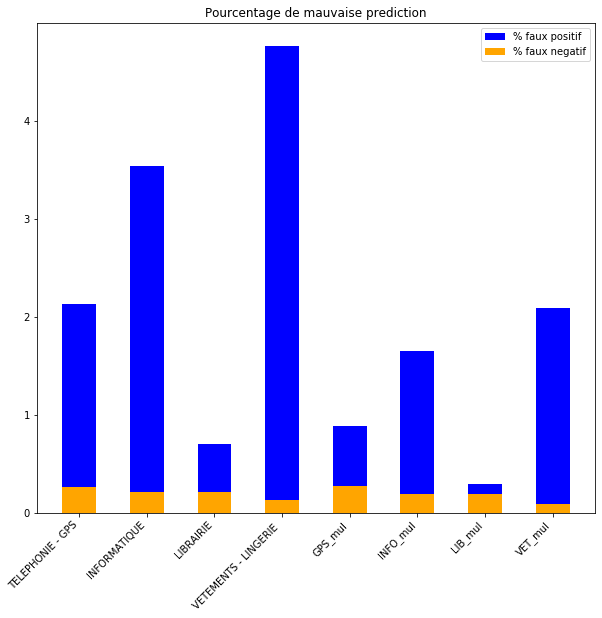

In [22]:
bar_plot_false(cat,PFP,PFN)

In [23]:
def bar_plot_error(cat,err):
    fig = plt.figure(figsize=(10,10))
    plt.bar(cat,err,width = 0.5, color = 'green', label="% d'erreur")
    plt.title("Erreur de prediction")
    plt.legend()
    fig.autofmt_xdate(rotation=45)

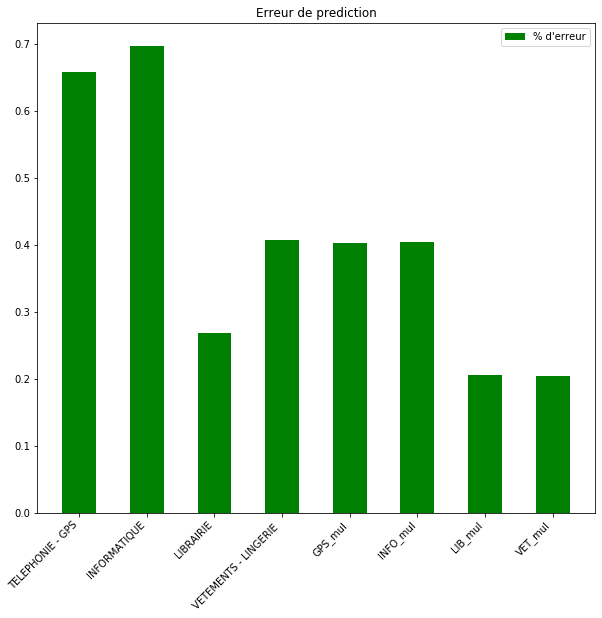

In [24]:
bar_plot_error(cat,err2)

### Comments : 

* Pour les regressions binaires, chaque regresseur est independant des autres ainsi un objet peut etre classé dans une catégorie A pour une regressif mais etgalement dans une categorie B pour une autre regression.
* ie, un produit d'informatique peut etre classé comme appartenant a cette catégorie lorsque qu'on fait la regression binaire sur INFO cependant ce meme produit peu etre classé comme appartenant à GPS quand on fait la regression sur la categorie GPS, dès lors il contribue au taux de faux positifs de la catégorie GPS.


* En regression multinomiale, toutes les catégories sont traitées en meme temps donc un produit ne peut etre classé que dans 1 seule catégorie. 
* ie, un faux positif d'une catégorie A va forcément augmenter le taux de faux négatif de B (avec B la véritable catégorie du produit).


## Reduction X train

In [42]:
#a mettre dans une fonction ! (arguments : nb et categorie)
nb = [500,1000,10000,50000,70000]

X_mul_1 = X_train[0:nb[0]] #multi sur 10k
y_mul_1 = y_train[0:nb[0]]

X_mul_2 = X_train[0:nb[1]] #multi sur 50k
y_mul_2 = y_train[0:nb[1]]


X_mul_3 = X_train[0:nb[2]] #multi sur 70k
y_mul_3 = y_train[0:nb[2]]


X_gps_1 = X_train_1[0:nb[0]] #binaire sur 10k
y_gps_1 = y_train_1[0:nb[0]]

X_gps_2 = X_train_1[0:nb[1]] #binaire sur 50k
y_gps_2 = y_train_1[0:nb[1]]

X_gps_3 = X_train_1[0:nb[2]] #binaire sur 70k
y_gps_3 = y_train_1[0:nb[2]]

In [43]:
#nos regresseurs 
lr_mul_1 = LogisticRegression()
lr_mul_2 = LogisticRegression()
lr_mul_3 = LogisticRegression()

lr_gps_1 = LogisticRegression()
lr_gps_2 = LogisticRegression()
lr_gps_3 = LogisticRegression()

#regression mul sur 10k, 50k, 70k
lr_mul_1.fit(X_mul_1, y_mul_1)
lr_mul_2.fit(X_mul_2, y_mul_2)
lr_mul_3.fit(X_mul_3, y_mul_3)


#regression binaire sur 10k, 50k, 70k
lr_gps_1.fit(X_gps_1,y_gps_1)
lr_gps_2.fit(X_gps_2,y_gps_2)
lr_gps_3.fit(X_gps_3,y_gps_3)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
#predictions avec nos regresseurs multinomiales
predict_mul_1=lr_mul_1.predict(X_test)
predict_mul_2=lr_mul_2.predict(X_test)
predict_mul_3=lr_mul_3.predict(X_test)

In [45]:
#extraction des réponses predites GPS avec nos regresseurs mul
predict_gps_1 = predict_mul_1=="TELEPHONIE - GPS" #valeurs predites
predict_gps_2 = predict_mul_2=="TELEPHONIE - GPS"
predict_gps_3 = predict_mul_3=="TELEPHONIE - GPS"

y_test_gps = np.array(y_test)=="TELEPHONIE - GPS" #valeurs attendues


cross_tab_1 = pd.crosstab(y_test_gps, predict_gps_1, rownames=["Ground True"], colnames=["Prediction"])
cross_tab_2 = pd.crosstab(y_test_gps, predict_gps_2, rownames=["Ground True"], colnames=["Prediction"])
cross_tab_3 = pd.crosstab(y_test_gps, predict_gps_3, rownames=["Ground True"], colnames=["Prediction"])

#calcul des scores sur GPS avec les reg mul
score_mul_1= sum(np.diag(cross_tab_1))/sum(cross_tab_1.sum())
score_mul_2= sum(np.diag(cross_tab_2))/sum(cross_tab_2.sum())
score_mul_3= sum(np.diag(cross_tab_3))/sum(cross_tab_3.sum())

In [46]:
print("Affichage des scores de test: \n")
print("   Données GPS issues de la regMultinomiale \n")
print(score_mul_1, "pour ", len(y_mul_1), "données d'apprentissage" )
print(score_mul_2, "pour ", len(y_mul_2), "données d'apprentissage" )
print(score_mul_3, "pour ", len(y_mul_3), "données d'apprentissage \n")
print("  Données GPS issues de la regBinaire \n")
print(lr_gps_1.score(X_test_1,y_test_1), "pour ", len(y_gps_1), "données d'apprentissage" )
print(lr_gps_2.score(X_test_1,y_test_1), "pour ", len(y_gps_2), "données d'apprentissage" )
print(lr_gps_3.score(X_test_1,y_test_1), "pour ", len(y_gps_3), "données d'apprentissage \n" )

Affichage des scores de test: 

   Données GPS issues de la regMultinomiale 

0.9396 pour  500 données d'apprentissage
0.9431 pour  1000 données d'apprentissage
0.9792 pour  10000 données d'apprentissage 

  Données GPS issues de la regBinaire 

0.9497 pour  500 données d'apprentissage
0.9592 pour  1000 données d'apprentissage
0.9777 pour  10000 données d'apprentissage 



In [ ]:
#tracer une courbe, a comparer après avec la sol word2vec